In [1]:
# =============
# CARGA DE LIBRERIAS

import gc
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.preprocessing import StandardScaler
import torch

In [ ]:
# =============
# EXTRACCION Y PROCESAMIENTO DE LOS DATASETS DE ENTRENAMIENTO

# Directorio y parámetros generales
data_dir       = "data"
extra_dir      = "extra"
num_cols       = 5000
total_samples  = 3372890

# Mapeo de los tres archivos completos
flux_mm       = np.memmap(os.path.join(data_dir, "spectra_data_complete_flux.dat"),
                         dtype='float32', mode='r').reshape(total_samples, num_cols)
wave_mm       = np.memmap(os.path.join(data_dir, "spectra_data_complete_wavelength.dat"),
                         dtype='float32', mode='r').reshape(total_samples, num_cols)
redshift_mm   = np.memmap(os.path.join(data_dir, "spectra_data_complete_redshift.dat"),
                         dtype='float32', mode='r')

# Requerimientos para TRAIN: exactos por rango (numeros pseudoaleatorios)
train_required = {
    (0, 0.1):    66740,
    (0.1, 1):    361237,
    (1,   2):    27893,
    (2,   3):    32576,
    (3,   4):    11750,
    (4,   8):    4528,
}

# Muestreo estratificado para TRAIN (sin ningun filtrado previo)
train_idxs = []
for (lo, hi), count in train_required.items():
    # candidatos en el rango [lo, hi)
    cand = np.where((redshift_mm >= lo) & (redshift_mm < hi))[0]
    if len(cand) < count:
        print(f"[TRAIN] Rango [{lo}, {hi}): solo {len(cand)} disponibles, tomo todas.")
        sel = cand
    else:
        sel = np.random.choice(cand, size=count, replace=False)
    train_idxs.append(sel)
train_idxs = np.concatenate(train_idxs)

train_data = {
    "flux":     flux_mm[train_idxs],
    "wavelength": wave_mm[train_idxs],
    "redshift": redshift_mm[train_idxs].astype(np.float32).reshape(-1,1)
}

# Requerimientos para TEST: exactos por rango y disjuntos de TRAIN (numeros pseudoaleatorios)
test_required = {
    (0, 0.1):    12692,
    (0.1, 1):    68890,
    (1,   2):    5214,
    (2,   3):    6168,
    (3,   4):    2312,
    (4,   8):    0,
}

remaining = np.setdiff1d(np.arange(total_samples), train_idxs, assume_unique=True)

test_idxs = []
for (lo, hi), count in test_required.items():
    # de los indices remanentes, filtrar por rango
    cand = remaining[(redshift_mm[remaining] >= lo) & (redshift_mm[remaining] < hi)]
    if len(cand) < count:
        print(f"[TEST ] Rango [{lo}, {hi}): solo {len(cand)} disponibles, tomo todas.")
        sel = cand
    else:
        sel = np.random.choice(cand, size=count, replace=False)
    test_idxs.append(sel)
test_idxs = np.concatenate(test_idxs)

test_data = {
    "flux":     flux_mm[test_idxs],
    "wavelength": wave_mm[test_idxs],
    "redshift": redshift_mm[test_idxs].astype(np.float32).reshape(-1,1)
}

In [ ]:
# Escalado y guardado de los datos

# # Instanciar los dos scalers (descomentar esta parte en caso de querer fittear el scaler con otros datos)
# scaler_path = os.path.join(extra_dir, "scaler_stars_fitted.pkl")
# flux_scaler = StandardScaler()           # para normalizar los datos de flux
# wavelength_scaler = StandardScaler()     # para normalizar los datos de wavelength

# # Ajustar cada scaler con los datos de entrenamiento correspondientes
# flux_scaler.fit(train_data["flux"])
# wavelength_scaler.fit(train_data["wavelength"])

# # Guardar ambos scalers en pickle
# scaler_dict = {
#     "flux_scaler": flux_scaler,
#     "wavelength_scaler": wavelength_scaler
# }
# with open(scaler_path, "wb") as f:
#     pickle.dump(scaler_dict, f)
# print(f"Scalers guardados en {scaler_path}")

# Cargamos el scaler
scaler_filename = os.path.join(extra_dir, "scaler_fitted.pkl")
with open(scaler_filename, "rb") as f:
    scaler_dict = pickle.load(f)
flux_scaler = scaler_dict["flux_scaler"]
wavelength_scaler = scaler_dict["wavelength_scaler"]

# Normalizar train y test usando los scalers adecuados
flux_train_scaled = flux_scaler.transform(train_data["flux"])
flux_test_scaled  = flux_scaler.transform(test_data["flux"])
wave_train_scaled = wavelength_scaler.transform(train_data["wavelength"])
wave_test_scaled  = wavelength_scaler.transform(test_data["wavelength"])

# Convertir a tensores torch
train_600k = {
    "flux":       torch.from_numpy(flux_train_scaled).float(),
    "wavelength": torch.from_numpy(wave_train_scaled).float(),
    "redshift":   torch.from_numpy(train_data["redshift"]).float()
}
test_600k = {
    "flux":       torch.from_numpy(flux_test_scaled).float(),
    "wavelength": torch.from_numpy(wave_test_scaled).float(),
    "redshift":   torch.from_numpy(test_data["redshift"]).float()
}

# Guardar los datasets resultantes
torch.save(train_600k, os.path.join(data_dir, "train_dataset_600k.pt"))
torch.save(test_600k,  os.path.join(data_dir, "test_dataset_600k.pt"))

In [ ]:
# Conteo objetivo tras la ampliacion
test_target = {
    (0, 0.1):    32732,
    (0.1, 1):    251162,
    (1,   2):    175701,
    (2,   3):    112582,
    (3,   4):    18659,
    (4,   8):    4440,
}

# Preparar candidatos: cualquier índice que NO este en test_idxs (puede incluir train_idxs)
all_idxs  = np.arange(total_samples)
remaining = np.setdiff1d(all_idxs, test_idxs, assume_unique=True)

# Para cada rango, muestrear el deficit
additional = []
for (lo, hi), target in test_target.items():
    have = test_required[(lo, hi)]
    need = target - have
    if need <= 0:
        continue

    # Filtrar candidatos en este rango de redshift
    mask = (redshift_mm[remaining] >= lo) & (redshift_mm[remaining] < hi)
    cand = remaining[mask]

    # Si hay menos candidatos que necesidad, tomamos todos; si no, muestreamos aleatoriamente
    if len(cand) < need:
        print(f"[WARN] Rango [{lo}, {hi}): solo {len(cand)} candidatos, añadiendo todos.")
        sel = cand
    else:
        sel = np.random.choice(cand, size=need, replace=False)

    additional.append(sel)

# Actualizar test_idxs con los nuevos indices
if additional:
    additional = np.concatenate(additional)
    test_idxs   = np.concatenate([test_idxs, additional])

# Reconstruir y escalar el dataset ampliado
flux_scaled = flux_scaler.transform( flux_mm[test_idxs] )
wave_scaled = wavelength_scaler.transform( wave_mm[test_idxs] )

test_1M = {
    "flux":       torch.from_numpy(flux_scaled).float(),          # normalizado con scaler_flux
    "wavelength": torch.from_numpy(wave_scaled).float(),          # normalizado con scaler_wave
    "redshift":   torch.from_numpy(
                      redshift_mm[test_idxs]
                      .astype(np.float32)
                      .reshape(-1,1)
                  ).float()                                        # reshape a [N,1]
}

# Guardar el test ampliado
torch.save(test_1M, os.path.join(data_dir, "test_dataset_1M.pt"))

Número de espectros: 504724


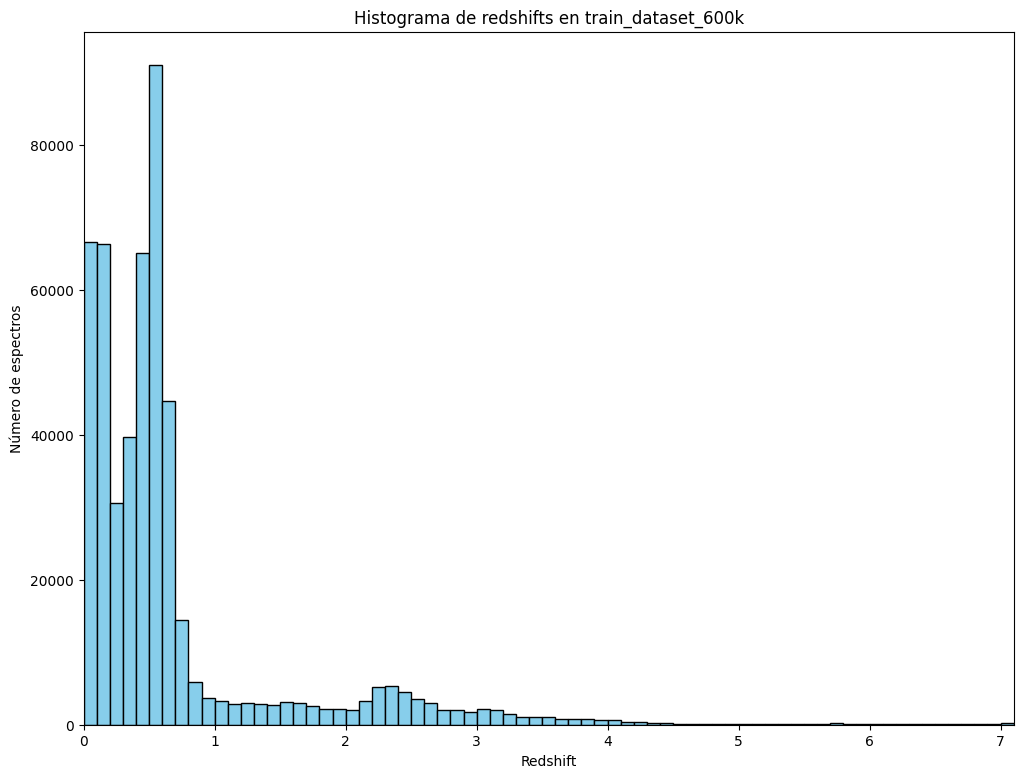

In [ ]:
data_dir = "data"
dataset_path = os.path.join(data_dir, "train_dataset_600k.pt")

dataset = torch.load(dataset_path)

redshift_array = dataset["redshift"].squeeze().numpy()
print("Número de espectros:", len(redshift_array))

bins = np.arange(0, redshift_array.max() + 0.1, 0.1)

# Crear y mostrar el histograma para visualizar la distribucion del redshift de los espectros de los datasets
plt.figure(figsize=(12,9))
plt.hist(redshift_array, bins=bins, color='skyblue', edgecolor='black')
plt.xlabel("Redshift")
plt.ylabel("Número de espectros")
plt.title("Histograma de redshifts en train_dataset_600k")
plt.xlim(0, 7.1)
plt.show()

In [ ]:
# =============
# PROCESAMIENTO DEL CONJUNTO COMPLETO DE DATOS

# Parametros generales
data_dir = "data"                      # Directorio donde se encuentran y se guardaran los datos
extra_dir = "extra"                    # Directorio donde se encuentra el scaler
os.makedirs(extra_dir, exist_ok=True)  # Asegurarse que extra existe
total_complete = 3372890               # Numero total de espectros en el dataset completo
num_points = 5000                      # Numero de puntos por espectro
chunk_size = 10000                     # Tamaño del chunk para procesamiento
split_index = total_complete // 2      # Indice para dividir en dos mitades (necesario ya que al cargarlo al completo supera el limite de memoria)

# Cargar Scalers
scaler_filename = os.path.join(extra_dir, "scaler_fitted.pkl")
with open(scaler_filename, "rb") as f:
    scaler_dict = pickle.load(f)
flux_scaler = scaler_dict["flux_scaler"]
wavelength_scaler = scaler_dict["wavelength_scaler"]

# Crear memmaps de los datos no procesados

complete_flux_path     = os.path.join(data_dir, "spectra_data_complete_flux.dat")
complete_wave_path     = os.path.join(data_dir, "spectra_data_complete_wavelength.dat")
complete_redshift_path = os.path.join(data_dir, "spectra_data_complete_redshift.dat")

flux_complete = np.memmap(complete_flux_path, dtype="float32", mode="r", shape=(total_complete, num_points))
wavelength_complete = np.memmap(complete_wave_path, dtype="float32", mode="r", shape=(total_complete, num_points))
redshift_complete = np.memmap(complete_redshift_path, dtype="float32", mode="r", shape=(total_complete,))

# Se crean memmaps para almacenar los datos escalados
flux_scaled_path = os.path.join(data_dir, "flux_complete_scaled.dat")
wavelength_scaled_path = os.path.join(data_dir, "wavelength_complete_scaled.dat")

flux_complete_scaled = np.memmap(flux_scaled_path, dtype="float32", mode="w+", shape=(total_complete, num_points))
wavelength_complete_scaled = np.memmap(wavelength_scaled_path, dtype="float32", mode="w+", shape=(total_complete, num_points))

print("Normalizando flux y wavelength en bloques...")
for start in range(0, total_complete, chunk_size):
    end = min(start + chunk_size, total_complete)
    # Aplicar escalado a cada chunk
    flux_complete_scaled[start:end] = flux_scaler.transform(flux_complete[start:end])
    wavelength_complete_scaled[start:end] = wavelength_scaler.transform(wavelength_complete[start:end])
    print(f"Procesado de índices {start} a {end}")

# Asegurarse de escribir en disco y liberar memoria
flux_complete_scaled.flush()
wavelength_complete_scaled.flush()
del flux_complete, wavelength_complete
gc.collect()

# Rutas para los memmaps de salida de cada mitad
flux1_memmap_path       = os.path.join(data_dir, "flux1.dat")
flux2_memmap_path       = os.path.join(data_dir, "flux2.dat")
wavelength1_memmap_path = os.path.join(data_dir, "wavelength1.dat")
wavelength2_memmap_path = os.path.join(data_dir, "wavelength2.dat")
redshift1_memmap_path   = os.path.join(data_dir, "redshift1.dat")
redshift2_memmap_path   = os.path.join(data_dir, "redshift2.dat")

# Crear los memmaps para cada mitad
flux1_memmap       = np.memmap(flux1_memmap_path, dtype="float32", mode="w+", shape=(split_index, num_points))
flux2_memmap       = np.memmap(flux2_memmap_path, dtype="float32", mode="w+", shape=(total_complete - split_index, num_points))
wavelength1_memmap = np.memmap(wavelength1_memmap_path, dtype="float32", mode="w+", shape=(split_index, num_points))
wavelength2_memmap = np.memmap(wavelength2_memmap_path, dtype="float32", mode="w+", shape=(total_complete - split_index, num_points))
redshift1_memmap   = np.memmap(redshift1_memmap_path, dtype="float32", mode="w+", shape=(split_index,))
redshift2_memmap   = np.memmap(redshift2_memmap_path, dtype="float32", mode="w+", shape=(total_complete - split_index,))

# Abrir los memmaps escalados en modo lectura
flux_scaled       = np.memmap(flux_scaled_path, dtype="float32", mode="r", shape=(total_complete, num_points))
wavelength_scaled = np.memmap(wavelength_scaled_path, dtype="float32", mode="r", shape=(total_complete, num_points))
redshift_complete = np.memmap(complete_redshift_path, dtype="float32", mode="r", shape=(total_complete,))  # Redshift se encuentra en el archivo original, no se escala

print("Dividiendo el dataset en dos mitades en bloques...")
for start in range(0, total_complete, chunk_size):
    end = min(start + chunk_size, total_complete)

    # Procesar flux
    flux_chunk = flux_scaled[start:end]
    if end <= split_index:
        flux1_memmap[start:end] = flux_chunk
    elif start >= split_index:
        flux2_memmap[start - split_index: end - split_index] = flux_chunk
    else:
        flux1_memmap[start:split_index] = flux_chunk[:split_index - start]
        flux2_memmap[0: end - split_index] = flux_chunk[split_index - start:]
    
    # Procesar wavelength
    wavelength_chunk = wavelength_scaled[start:end]
    if end <= split_index:
        wavelength1_memmap[start:end] = wavelength_chunk
    elif start >= split_index:
        wavelength2_memmap[start - split_index: end - split_index] = wavelength_chunk
    else:
        wavelength1_memmap[start:split_index] = wavelength_chunk[:split_index - start]
        wavelength2_memmap[0: end - split_index] = wavelength_chunk[split_index - start:]
    
    # Procesar redshift (1D)
    redshift_chunk = redshift_complete[start:end]
    if end <= split_index:
        redshift1_memmap[start:end] = redshift_chunk
    elif start >= split_index:
        redshift2_memmap[start - split_index: end - split_index] = redshift_chunk
    else:
        redshift1_memmap[start:split_index] = redshift_chunk[:split_index - start]
        redshift2_memmap[0: end - split_index] = redshift_chunk[split_index - start:]
    
    if start % (chunk_size * 10) == 0:
        print(f"Dividido índices {start} a {end}")

# Asegurar escritura en disco y liberar memoria
flux1_memmap.flush();       flux2_memmap.flush()
wavelength1_memmap.flush(); wavelength2_memmap.flush()
redshift1_memmap.flush();   redshift2_memmap.flush()
del flux_scaled, wavelength_scaled, redshift_complete
torch.cuda.empty_cache()
gc.collect()

# Convertimos ahora los memmaps divididos a tensores y guardamos

print("Convirtiendo y guardando los fluxes a tensores...")

# Flux
flux1_tensor = torch.from_numpy(np.array(np.memmap(flux1_memmap_path, dtype="float32", mode="r", shape=(split_index, num_points))))
flux2_tensor = torch.from_numpy(np.array(np.memmap(flux2_memmap_path, dtype="float32", mode="r", shape=(total_complete - split_index, num_points))))
torch.save(flux1_tensor, os.path.join(data_dir, "flux1.pt"))
torch.save(flux2_tensor, os.path.join(data_dir, "flux2.pt"))

del flux1_tensor, flux2_tensor
torch.cuda.empty_cache()
gc.collect()

print("Convirtiendo y guardando los wavelengths a tensores...")

# Wavelength
wavelength1_tensor = torch.from_numpy(np.array(np.memmap(wavelength1_memmap_path, dtype="float32", mode="r", shape=(split_index, num_points))))
wavelength2_tensor = torch.from_numpy(np.array(np.memmap(wavelength2_memmap_path, dtype="float32", mode="r", shape=(total_complete - split_index, num_points))))
torch.save(wavelength1_tensor, os.path.join(data_dir, "wavelength1.pt"))
torch.save(wavelength2_tensor, os.path.join(data_dir, "wavelength2.pt"))

del wavelength1_tensor, wavelength2_tensor
torch.cuda.empty_cache()
gc.collect()

# Redshift (ajustamos aqui a dimensiones [N, 1])
redshift1_tensor = torch.from_numpy(np.array(np.memmap(redshift1_memmap_path, dtype="float32", mode="r", shape=(split_index,)))).unsqueeze(1)
redshift2_tensor = torch.from_numpy(np.array(np.memmap(redshift2_memmap_path, dtype="float32", mode="r", shape=(total_complete - split_index,)))).unsqueeze(1)
torch.save(redshift1_tensor, os.path.join(data_dir, "redshift1.pt"))
torch.save(redshift2_tensor, os.path.join(data_dir, "redshift2.pt"))

print("Proceso completado. Archivos finales guardados exitosamente.")

In [ ]:
# =============
# RENORMALIZACION DE LOS DATOS PARA GANAR PODER DE GENERALIZACION

# Cargar dataset original
data = torch.load("data/test_dataset_1M.pt")
flux       = data["flux"]
wavelength = data["wavelength"]
redshift   = data.get("redshift", None)
del data

# Cargar scalers originales
with open("extra/scaler_fitted.pkl", "rb") as f:
    scaler_dict = pickle.load(f)
flux_scaler = scaler_dict["flux_scaler"]
wave_scaler = scaler_dict["wavelength_scaler"]

# Invertir la normalizacion original
flux_np   = flux.numpy()
wave_np   = wavelength.numpy()
del flux, wavelength
flux_orig = flux_scaler.inverse_transform(flux_np)
wave_orig = wave_scaler.inverse_transform(wave_np)
del flux_np, wave_np

# Renormalizar
flux_new = flux_orig / flux_orig.max(axis=1, keepdims=True)
del flux_orig
wave_shifted = wave_orig - wave_orig.mean(axis=1, keepdims=True)
del wave_orig
wave_new = wave_shifted / np.abs(wave_shifted).max(axis=1, keepdims=True)
del wave_shifted

flux_t = torch.from_numpy(flux_new)
wave_t = torch.from_numpy(wave_new)
out = {"flux": flux_t, "wavelength": wave_t, "redshift": redshift}

torch.save(out, "data/test_dataset_1M_renorm.pt")